 NOTE:
 The code is written in **vscode** and suitable to run with it, also, the venv folder is associated so, select the python interpretor to the venv's and go!

  # Library, Frameworks import statements

In [1]:
import random
import os
import re
import math
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn import tree
from pathlib import Path
from graphviz import Source
from subprocess import call
from IPython.display import display, SVG



  ## Functions definitions

In [2]:
def pre_process():
    cwd = os.getcwd()
    n_files = 0     # files count
    for file in os.listdir('row_data'):
        file_path = Path(cwd + "\\row_data\\")
        file_path = file_path / file
        n_files += 1
        with open(file_path, 'r') as in_f:
            regex = r'<form(.|\n)*<\/form>'
            content = in_f.read()
            for match in re.finditer(regex, content):
                with open(Path(cwd + '\\data\\') / file, 'w') as out_f:
                    out_f.write(match.group())  
    return n_files

def extract_label_input(content, features, labels):
    '''
    Function to catch features of the form
    <label>..</label>
    <input>..</input>
    IN: content: <div>..</div> which contains both input, label tags
        features: string list to store the features
        labels: string list to store the labels
    OUT: the updated lists: features, labels
    '''
    # Match the pattern label-input
    for match in re.finditer(r'<label[\s\S]*?<input[\s\S]*?>', content):
        #print("Inner \n",match.group(), 50*"-", "\n")
        Label = re.findall(r'<label[\s\S]*?</label>', match.group())[0]
        Input = re.findall(r'<input[\s\S]*"[\s\S]*>', match.group())[0]
        #print("Label: ", Label, "\nInput: ", Input, "\n")

        # Now, check if the matched don't follow input, label pattern
        # Then, return None
        if None in (Input, Label):
            return None

        #print("Match: ", match.group())
        # Check if label is for this input
        label_for = re.findall(r'(?<=for=")[\s\S]*?(?=")', match.group())[0]
        input_id = re.findall(r'(?<=id=")[\s\S]*?(?=")', match.group())[0]
        #print("\nLabel for: ", label_for, "\tInput id= ", input_id)
        if(label_for != input_id):
            return None
        
        # Extract input type, and text btw <label> tags 
        input_type = re.findall(r'(?<=type=")[\s\S]*?(?=")', Input)[0]
        labl_txt = re.findall(r'(?<=>)[\w\s\-/\*]+(?=\s*:?\s*</label>)', Label)[0].strip(' .*#!').lower()

        #print("\nInput Type: ", input_type, "\tLabel text: ", labl_txt)
      
        # append
        features.append([label_for, labl_txt, input_type])
        labels.append([input_id])    

def build_features_labels(feature_lst, label_lst):
    cwd = os.getcwd()
    n_files = 0     # files count
    for file in os.listdir('data'):
        file_path = Path(cwd + '\\data\\') / file
        with open(file_path, 'r') as in_f:
            # Catch input, label inside <div> tags
            div_regex = r'<div[\s\S]*?<\/div>'
            content = in_f.read()
            for match in re.finditer(div_regex, content):
                # Now, check if the code between <div> tags contains <input>
                if "<input" in match.group():
                    #print(match.group())
                    #print("\n",50*"=", "\n")
                    #print("File name: ", file)
                    extract_label_input(match.group(), feature_lst, label_lst)
        
                
def divide_corpus(n_files):
    # A function used to divide teh corpus into train & test datasets
    # In: # of files 
    # Out: train_files: set of file numbers to be used in training
    #      test_files: set of file numbers to be used in testing

    # Select randomly the train, test dataset 
    train_files = set()
    test_files = set()
    
    for i in range(math.floor(n_files*0.6+1)):
        rand = random.randint(1, n_files+1)
        while rand in train_files:
            rand = random.randint(1, n_files+1)
        train_files.add(rand)
    
    test_files = set([x for x in range(1, n_files+1)]) - train_files
    
    return train_files, test_files
    
def predict(div):
    # In:   div tag
    # Out:  Prediction probability
    # Extract features using regex
    div_regex = r'<div[\s\S]*?<\/div>'
    for match in re.finditer(div_regex, div):
        # Now, check if the code between <div> tags contains <input>
        if "<input" in match.group():
            # Match the pattern label-input
            for match in re.finditer(r'<label[\s\S]*?<input[\s\S]*?>', div):
                #print("Inner \n",match.group(), 50*"-", "\n")
                Label = re.findall(r'<label[\s\S]*?</label>', match.group())[0]
                Input = re.findall(r'<input[\s\S]*"[\s\S]*>', match.group())[0]
                #print("Label: ", Label, "\nInput: ", Input, "\n")

                # Now, check if the matched don't follow input, label pattern
                # Then, return None
                if None in (Input, Label):
                    return "Invalid Input 'pattern label-input'"

                #print("Match: ", match.group())
                # Check if label is for this input
                label_for = re.findall(r'(?<=for=")[\s\S]*?(?=")', match.group())[0]
                
                # Extract input type, and text btw <label> tags 
                input_type = re.findall(r'(?<=type=")[\s\S]*?(?=")', Input)[0]
                labl_txt = re.findall(r'(?<=>)[\w\s/\*]+(?=\s*:?\s*</label>)', Label)[0].strip(' .*#!').lower()
                
                # Now, encode strings into numeric
                feature = [label_for, labl_txt, input_type]

                x = enc.transform([feature])

                y = clf.predict(x)
                p = clf.predict_proba(x)
                print("Input code: ",feature ,"\nPredicted input_id or input_name: ", le.inverse_transform(y), "\nProbability of prediction: \n")
                prob_df = pd.DataFrame(p, columns=[le.classes_])
    return prob_df




  # Main App:
   1. Preprocessing:

In [3]:
files_count = pre_process() 


   2. Building the model
 Encode the string labels & features into numerical values

In [4]:
feature_lst= []     # List of feature classes
label_lst = []      # List of label classes
build_features_labels(feature_lst, label_lst)
feature_df = pd.DataFrame(feature_lst, columns=['label_for', 'label_text', 'input_type'])
label_df = pd.DataFrame(label_lst, columns=['input_id'])
# Encode the string labels & features into numerical values
enc = OrdinalEncoder()
enc.fit(feature_lst)
x = enc.transform(feature_lst)   # numerical features

le = LabelEncoder()
le.fit(label_lst)
y = le.transform(label_lst)     # numerical labels


c:\users\hazem\documents\mega\attributepredictor\env\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hazem\documents\mega\attributepredictor\env\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
feature_df.style


,label_for,label_text,input_type
0,username,username,text
1,password,password,password
2,username,username,text
3,password,password,password
4,confirm-password,confirm password,password
5,full-name,full name,text
6,email,e-mail,email
7,first-name,first name,text
8,full-name,name,text
9,phone,phone,tel


In [6]:
label_df.style




,input_id
0,username
1,password
2,username
3,password
4,confirm-password
5,full-name
6,email
7,first-name
8,full-name
9,phone


# Classification & Cross Validation

In [7]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, x, y, cv=4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))




Accuracy: 0.98 (+/- 0.06)


c:\users\hazem\documents\mega\attributepredictor\env\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


## Manual Testing

In [19]:
classifier = clf.fit(x, y)
predict('\
<div>\
    <label for="username">username</label>\
    <input type="text" name="" id="">\
</div>\
')

Input code:  ['username', 'username', 'text'] 
Predicted input_id or input_name:  ['username'] 
Probability of prediction: 



,address,city,confirm-password,email,first-name,full-name,last-name,password,phone,postcode,state,username
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:

predict('\
<div>\
    <label for="username">email</label>\
    <input type="password" name="" id="">\
</div>\
')

Input code:  ['username', 'email', 'password'] 
Predicted input_id or input_name:  ['username'] 
Probability of prediction: 



,address,city,confirm-password,email,first-name,full-name,last-name,password,phone,postcode,state,username
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Visualizing the Decision Tree

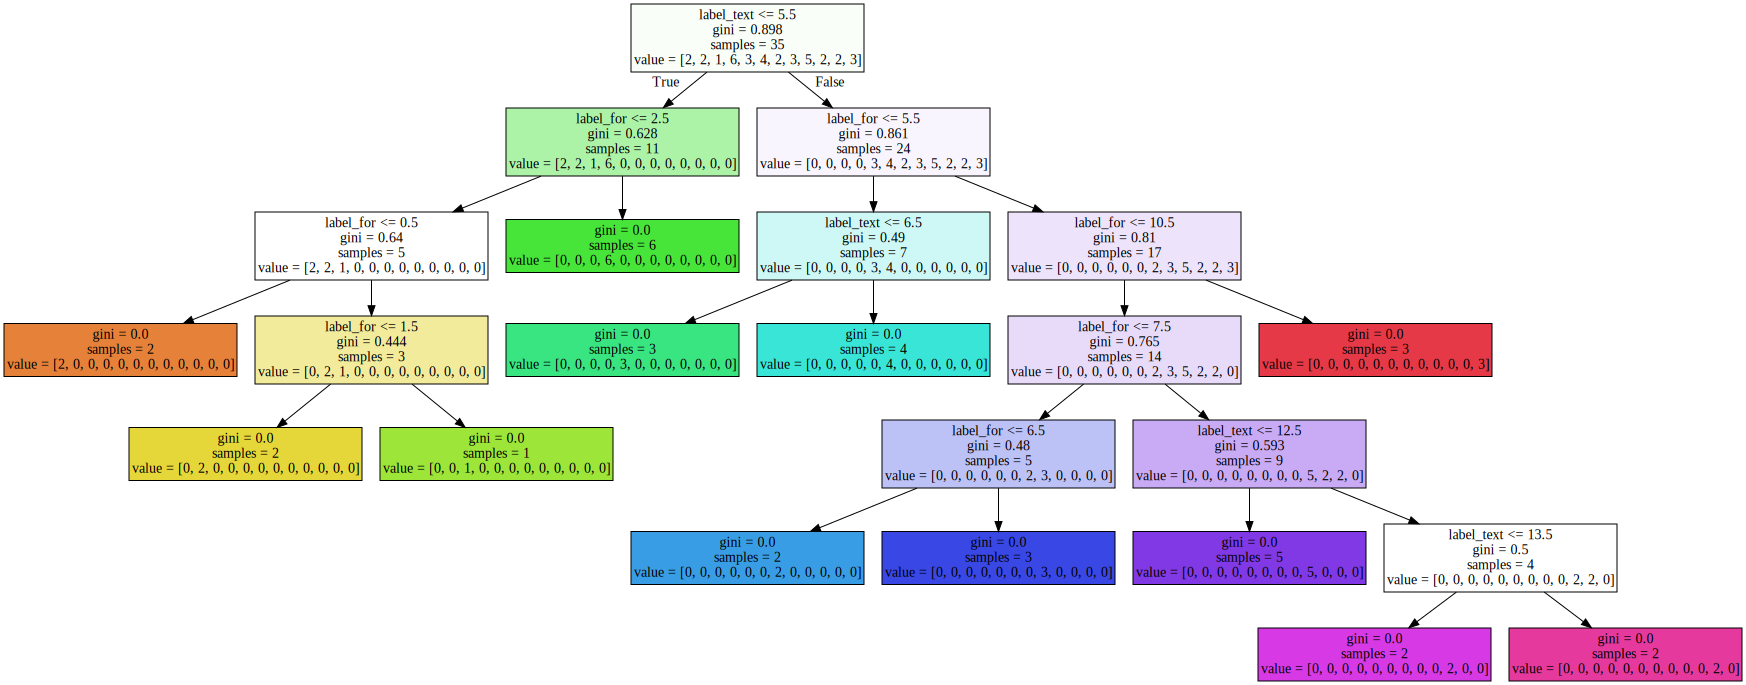

In [10]:
graph = Source(tree.export_graphviz(classifier, out_file=None,
   feature_names=['label_for', 'label_text', 'input_type'], 
   class_names=None,
   filled = True))

display(SVG(graph.pipe(format='svg')))